In [123]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='whitegrid', context='paper', 
                               rc={'font.size': 7, 
                                   'axes.titlesize': 9,
                                   'axes.labelsize': 8,
                                   'xtick.labelsize': 7,
                                   'ytick.labelsize': 7,
                                   'legend.fontsize' : 8,
                                   'legend.markerscale': 0.7,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Figure 1 - Dimensionality vs. encoding performance

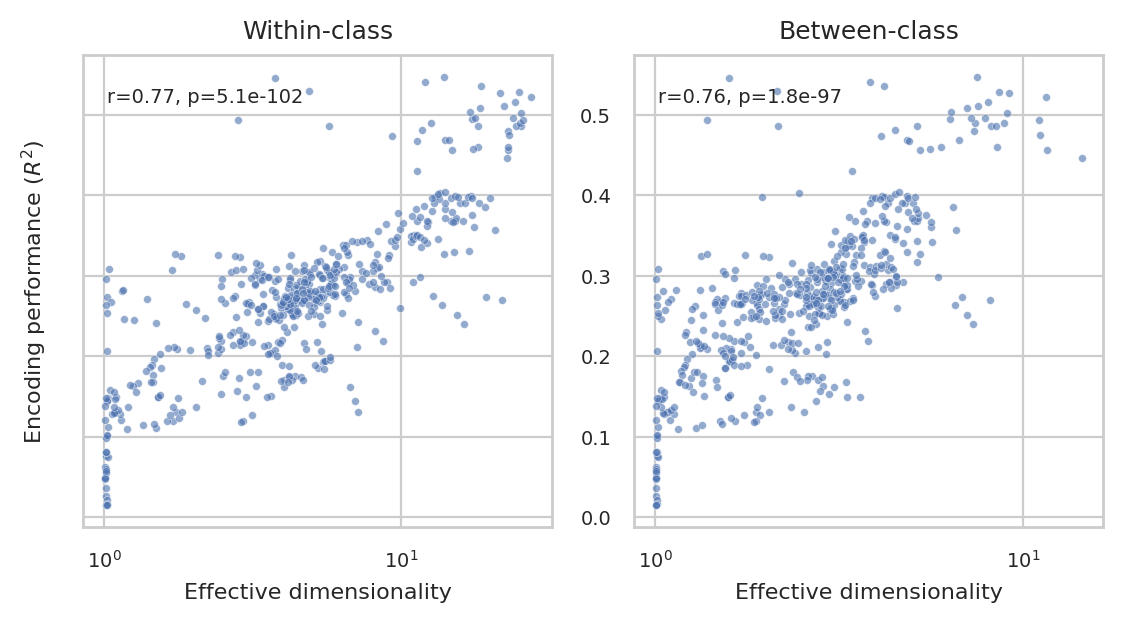

In [72]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(5.5, 3))

sns.scatterplot(data=data, x='within-concept dimensionality (mean)', y='score', alpha=0.6, s=8, ax=axs[0])
axs[0].set(title='Within-class', xlabel='Effective dimensionality', ylabel=r'Encoding performance ($R^2$)', yticklabels=[], xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', ax=axs[0])

sns.scatterplot(data=data, x='between-concept dimensionality', y='score', alpha=0.6, s=8, ax=axs[1])
axs[1].set(title='Between-class', xlabel='Effective dimensionality', ylabel=None, xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', ax=axs[1])

plt.savefig('saved/results_01_ED.png', dpi=300)
plt.show()

---
# Figure 2 - Dimensionality vs. layer depth

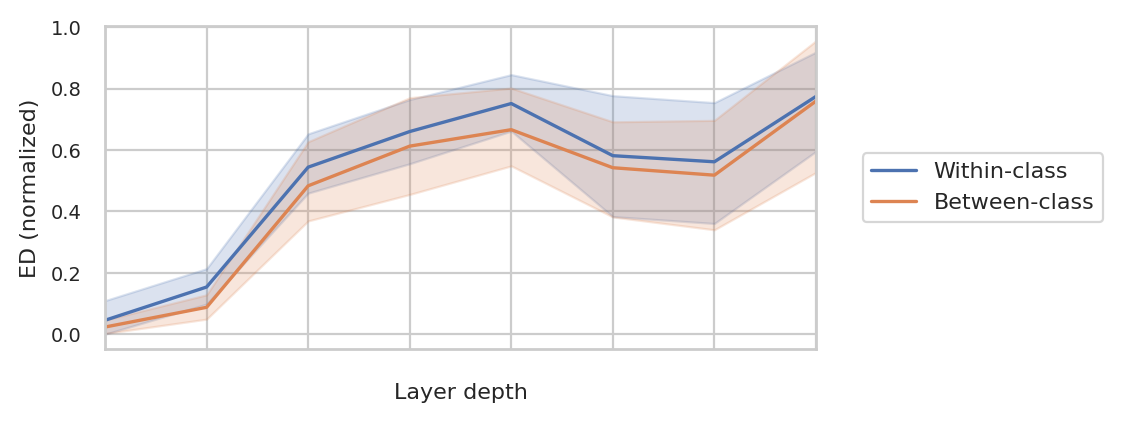

In [174]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.kind != 'Untrained') & (data.architecture == 'ResNet18')]

normed_metrics = data.groupby(['architecture', 'task', 'kind', 'source'])\
                     .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
normed_metrics = normed_metrics[['between-concept dimensionality', 'within-concept dimensionality (mean)']]
normed_metrics.columns = [c + ' normed' for c in normed_metrics.columns]
data = pd.concat([data, normed_metrics], axis=1)

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean) normed', 'between-concept dimensionality normed'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(5.5, 2))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED (normalized)', xticklabels=[], xlim=(0, 7))

ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', labels=['Within-class', 'Between-class'])

plt.savefig('saved/results_02_depth.png', dpi=300)
plt.show()

---
# Figure 3 - Dimensionality vs. encoding performance by layer

/home/eric/anaconda3/envs/bs/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


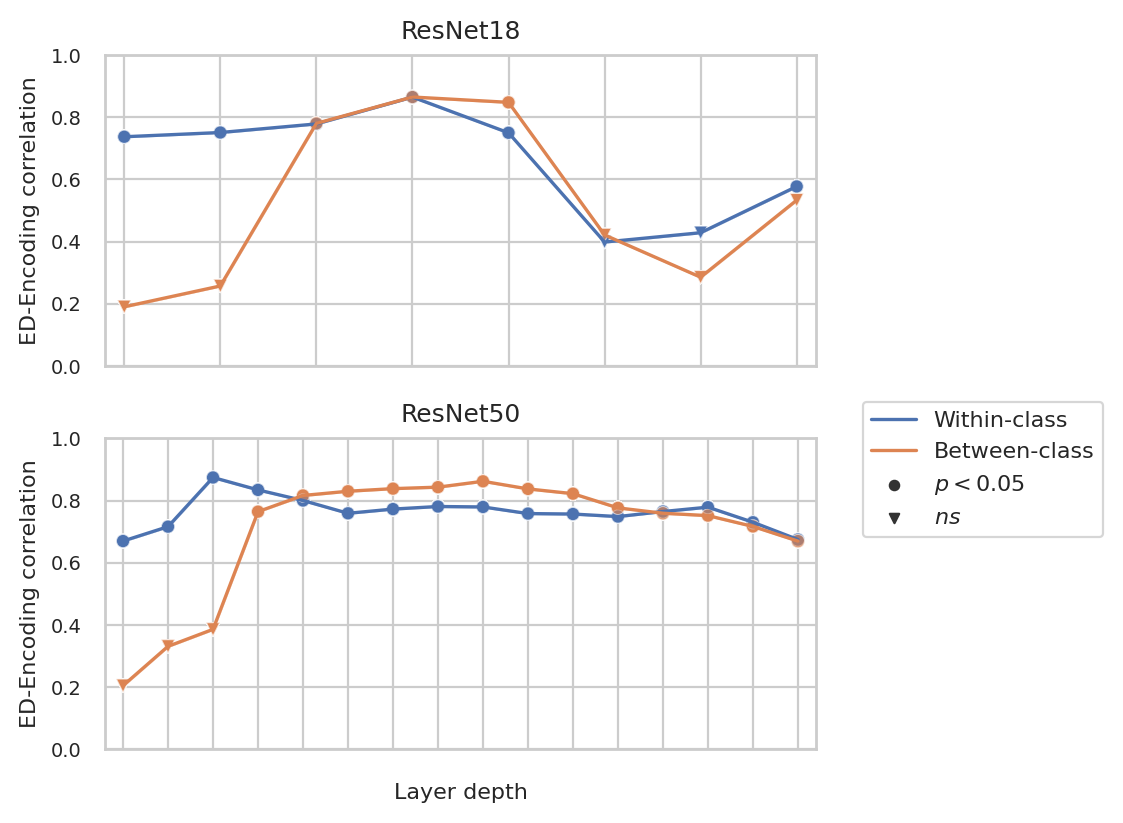

In [213]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] < 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, axs = plt.subplots(2, 1, figsize=(5.5, 4))

sns.lineplot(data=data[data.architecture == 'ResNet18'], x='layer', y='r_score_dim', hue='dim_type', ax=axs[0])
sns.scatterplot(data=data[(data.architecture == 'ResNet18')], 
                x='layer', y='r_score_dim', hue='dim_type', style='significant', 
                style_order=[True, False], markers=['o', 'v'], alpha=0.5, ax=axs[0])
axs[0].set(title='ResNet18', xlabel=None, ylabel='ED-Encoding correlation', xticklabels=[], xlim=(-0.2, 7.2), ylim=(0, 1))

sns.lineplot(data=data[data.architecture == 'ResNet50'], x='layer', y='r_score_dim', hue='dim_type', ax=axs[1])
sns.scatterplot(data=data[(data.architecture == 'ResNet50')], 
                x='layer', y='r_score_dim', hue='dim_type', style='significant', 
                style_order=[True, False], markers=['o', 'v'], alpha=0.5, ax=axs[1])
axs[1].set(title='ResNet50', xlabel='Layer depth', ylabel='ED-Encoding correlation', xticklabels=[], xlim=(-0.4, 15.4), ylim=(0, 1))

axs[0].legend().remove()
handles, _ = axs[1].get_legend_handles_labels()
axs[1].legend(bbox_to_anchor=(1.05, 0.9), loc='center left', 
              labels=['Within-class', 'Between-class', r'$p < 0.05$', r'$ns$'], 
              handles=handles[:2] + handles[-2:])

plt.savefig('saved/results_03_layerwise.png', dpi=300)
plt.show()

---
# Figure 4 - Training

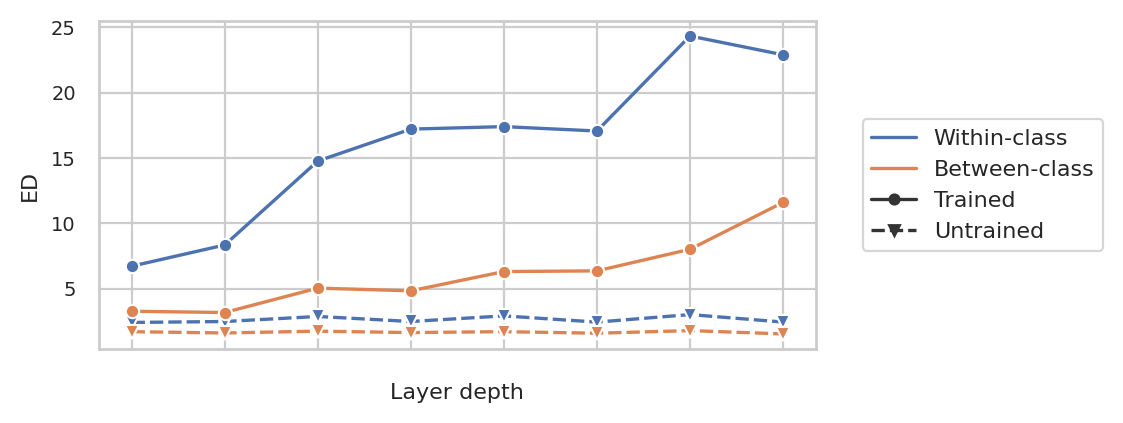

In [202]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.source == 'PyTorch') & (data.architecture == 'ResNet18')]

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(5.5, 2))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', style='kind',
             markers=['o', 'v'], style_order=['Supervised', 'Untrained'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED', xticklabels=[])

handles, _ = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', 
          labels=['Within-class', 'Between-class', 'Trained', 'Untrained'], 
          handles=handles[1:3] + handles[4:6])

plt.savefig('saved/results_04_training.png', dpi=300)
plt.show()

---
# Figure 5 - Classification